# Plan

Usual game — hook into the sim code to run episodes directly without the platform, with arbitrary controllers. Plot the results.

Confirm my assumption that given the precise model it's trivial to get it to run at any rate you'd like while being in-spec.

## Tracking sim bugs as I see them

* f_max and ω_max aren't used — no speed limits
* sim config not handled properly — uses defaults if no config at all is provided, but otherwise every 
  field must be set
* sim doesn't specify or enforce max accelerations. They seem to be in the Inkling only.
* sim add multiplicative noise to the actions:
   ```
        self.Δω_eff = self.Δω_s * (1 + σ_s)
        self.ω_s += Δt * self.Δω_eff
   ```      
  if the action is 0, there is no noise.       
* leftover cstr main() in main.py

## And sim questions

* Is max acceleration of 0.001 * max speed reasonable? It takes 1000 seconds to go from 0 to max speed for both the screw and the cutter?


In [1]:
%set_env PYTHONBREAKPOINT=IPython.core.debugger.set_trace

env: PYTHONBREAKPOINT=IPython.core.debugger.set_trace


In [2]:
# (Work around ipython + jedi bug in the version I have installed)
%config Completer.use_jedi = False

In [3]:
%matplotlib inline

In [4]:
import itertools
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

In [6]:
import main as m

In [7]:
sim = m.Simulation()

logfile: logs/2022-09-19-10-53-21_PVC_Extruder_log.csv
Checking /Users/vishnayd/Library/CloudStorage/OneDrive-Microsoft/code/bonsai-extruder/simulation/python/logs


```
def reset(
        self,
        noise: float = 0,
        ω0_s: float = 1e-6,
        Δω0_s: float = 0,
        f0_c: float = 1e-6,
        Δf0_c: float = 0,
        T: float = units.celsius_to_kelvin(190),
        demand: float = 0.1,
        cost: float = 0,
        selling_price: float = 0,
        L0: float = 1 * 12 * units.METERS_PER_INCH,
        ε: float = 0.1 * units.METERS_PER_INCH,
        config: dict = None
    ):
    
     self.default_config = {
            "noise": 0,
            "initial_screw_angular_speed": 1e-6,
            "initial_screw_angular_acceleration": 0,
            "initial_cutter_frequency": 1e-6,
            "initial_cutter_acceleration": 0,
            "initial_temperature": 463,
            "demand": 0.1,
            "cost": 0,
            "selling_price": 0
            }
            
def step(self, Δω_s: float, Δf_c: float):

def episode_step(self, action: Dict[str, Any]):
        """Called for each step of the episode 
        Parameters
        ----------
        action : Dict[str, Any]
            BrainAction chosen from the Bonsai Service, prediction or exploration
        """
        
        self.step(action.get("screw_angular_acceleration"), action.get("cutter_acceleration"))
```

In [8]:
default_config = {
            "noise": 0.01,
            "initial_screw_angular_speed": 1e-6,
            "initial_screw_angular_acceleration": 0,
            "initial_cutter_frequency": 1e-6,
            "initial_cutter_acceleration": 0,
            "initial_temperature": 463,
            "demand": 0.1,
            "cost": 0,
            "selling_price": 0
            }


In [9]:
def run_episode(sim, config, policy, max_steps=600):
    states = []
    actions = []
    sim.episode_start(config)
    for step in range(max_steps):
        if sim.halted():
            break
        
        state = sim.get_state()
        action = policy(state)
        sim.episode_step(action)
        states.append(state)
        actions.append(action)
        
    return states, actions

In [10]:
def null_policy(state):
    return {"screw_angular_acceleration":0,
            "cutter_acceleration":0}


In [11]:
# UNIT CONVERSIONS
MetersPerInch = 0.0254 # 1 inch = 0.0254 meters
RadiansPerRevolution = 2 * 3.14159

# CONTROL ACTIONS
ScrewSpeedMax = (200 / 60) * RadiansPerRevolution # radians / second
CutterFrequencyMax = 10 # hertz

ScrewAccelerationMax = 0.001 * ScrewSpeedMax # radians / second^2
CutterAccelerationMax = 0.001 * CutterFrequencyMax # 1 / second^2

# PRODUCT PARAMETERS
LengthTarget = 1 * 12 * MetersPerInch # meters
LengthTolerance = 0.1 * MetersPerInch # meters

InitialTemperature = 190 + 273.15 # Kelvin

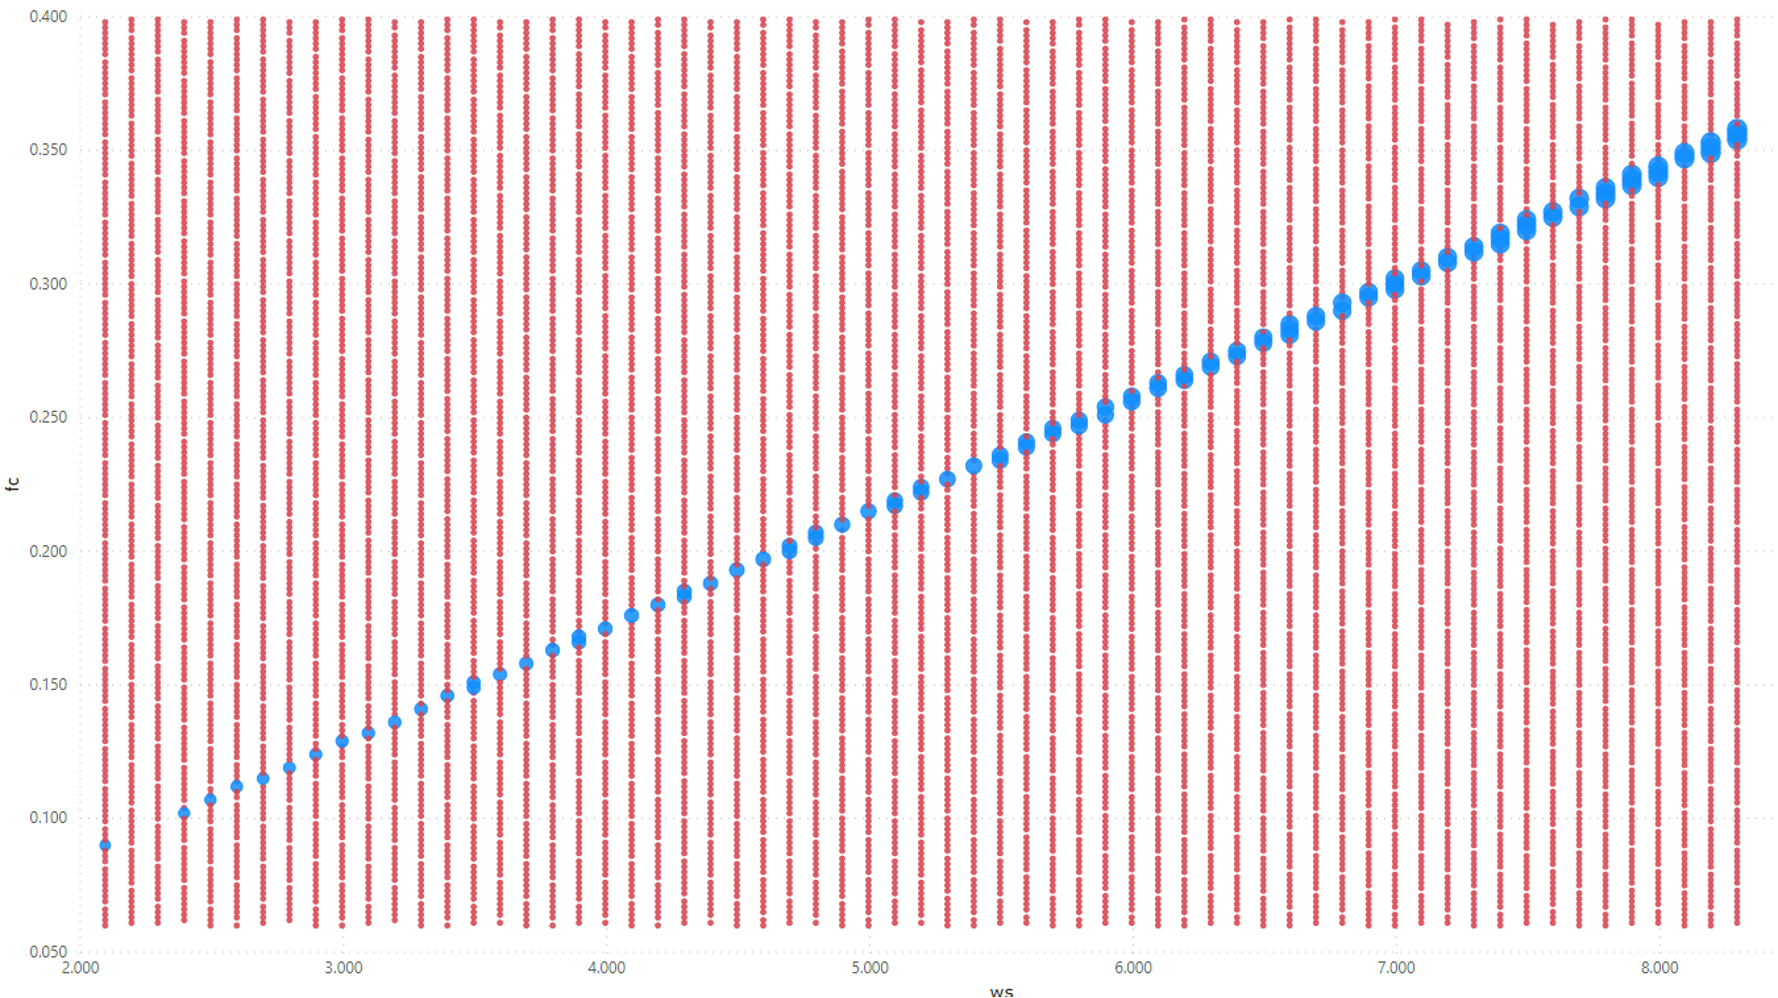

Being lazy and literally reading off two points here:

3.5, 0.15  
8.2, 0.35

So the line is

slope = (0.35 - 0.15)/(8.2-3.5) = 0.04255
intercept = 0.15 - 3.5 * slope = 0.00106

fc = ws * slope + intercept
ws = (fc - intercept) / slope

(Note: looks like intercept is just measurement error from eyeballing the chart)

In [12]:
def clamp(v, m, M):
    return max(m, min(v,M))

In [13]:
# I used the "produces bars of right length" line from the chart to estimate the constant below
def get_policy(target_production_rate):
    # target_production_rate: bars per unit time

    # define a function that will take a state, return an action
    def policy(state):
        current_screw_speed = state['screw_angular_speed']
        current_cutter_frequency = state['cutter_frequency']
        
        # because the time step is 1 sec, the production rate is the same as the cutter frequency
        final_cutter_frequency = target_production_rate
        
        # The target screw speed needs to be set based on the spec length and target rate
        target_screw_speed = (final_cutter_frequency) / 0.04255
        
        screw_speed_delta = clamp(target_screw_speed - current_screw_speed,
                                  -ScrewAccelerationMax, ScrewAccelerationMax)
       
        # to reduce waste, choose cutter speed based on screw speed to get right length parts 
        expected_screw_speed = current_screw_speed + screw_speed_delta
        target_cutter_frequency = expected_screw_speed * (0.04255)
        
        cutter_speed_delta = clamp(target_cutter_frequency - current_cutter_frequency, 
                                  -CutterAccelerationMax, CutterAccelerationMax)
        return {"cutter_acceleration": cutter_speed_delta,
                "screw_angular_acceleration": screw_speed_delta}

    return policy

In [14]:
ProductionTarget = 0.4
states,actions = run_episode(sim, default_config, get_policy(ProductionTarget))

In [15]:
len(states), len(actions)

(600, 600)

In [16]:
states[0]

{'screw_angular_speed': 1e-06,
 'screw_angular_acceleration': 0.0,
 'cutter_frequency': 1e-06,
 'cutter_acceleration': 0.0,
 'temperature': 463.0,
 'product_length': 0.013068359910717328,
 'flow_rate': 6.621835706298377e-12,
 'yield': 0.0,
 'efficiency': 0.0,
 'demand': 0.1,
 'total_cost': 0.0,
 'total_revenue': 0.0,
 'total_profit': 0.0,
 'parts_on_spec': 0.0,
 'cnt': 0.0}

In [17]:
states_df = pd.DataFrame(states)

In [18]:
def is_in_spec(x):
    return int(LengthTarget - LengthTolerance < x < LengthTarget + LengthTolerance)
    
states_df["in_spec"] = states_df.apply(lambda row: is_in_spec(row["product_length"]), axis=1)

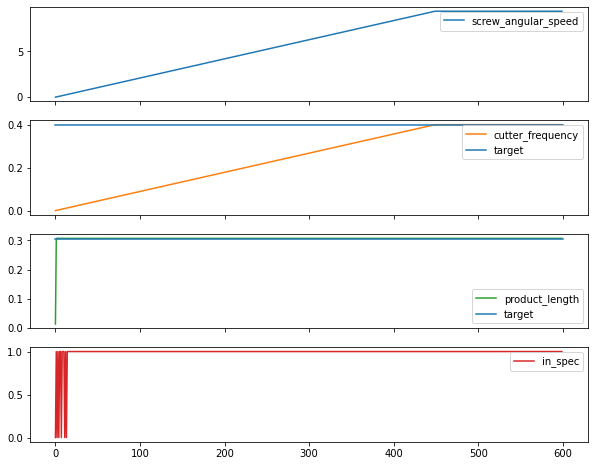

In [19]:
axes = states_df[["screw_angular_speed", "cutter_frequency", "product_length", "in_spec"]].plot(
    subplots=True, figsize=(10,8))

N = len(states)

# Add targets
axes[1].plot([0,N], [ProductionTarget, ProductionTarget], label='target')
axes[1].legend()
axes[2].plot([0,N],[LengthTarget,LengthTarget], label='target')
axes[2].legend()



# Tracking demand changes

Let's change the demand every 600 iterations

In [20]:
demand_schedule = [0.2,0.4,0.15, 0.3, 0.32, 0.2, 0.38]
demands = list(itertools.chain(*[[d]*600 for d in demand_schedule]))

In [21]:
def get_step_policy(demands):
    step = 0
    # return a policy function that depends on the demand 
    # (would be cleaner to put target production rate directly in the state, btw)
    def policy(*args):
        nonlocal step
        step += 1
        return get_policy(demands[step-1])(*args)
    
    return policy

In [22]:
states,actions = run_episode(sim, default_config, get_step_policy(demands), max_steps=len(demands))
states_df = pd.DataFrame(states)

states_df["demands"] = demands
states_df["in_spec"] = states_df.apply(lambda row: is_in_spec(row["product_length"]), axis=1)

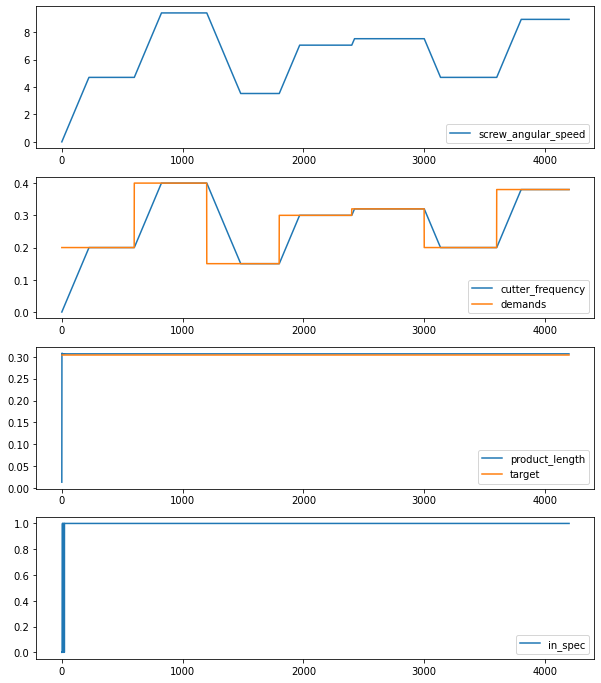

In [23]:
fig, axes = plt.subplots(4,1, figsize=(10,12))

states_df["screw_angular_speed"].plot(ax=axes[0])

# Demanded and actual frequency
states_df["cutter_frequency"].plot(ax=axes[1])
states_df["demands"].plot(ax=axes[1])

# actual length and target length
states_df["product_length"].plot(ax=axes[2])
N = len(states)
axes[2].plot([0,N],[LengthTarget,LengthTarget], label='target')

# in spec?
states_df["in_spec"].plot(ax=axes[3])

axes[0].legend()
axes[1].legend()
axes[2].legend()
axes[3].legend()

# Including the demand tracking concept

Ok, now let's compute the optimal demand rate. First, let's summarize how the sim works:

Config:
* demand — says "parts/sec" 
   * Inkling value is 120 - 140, so presumably total actually
* cost — material cost kg/s (0.86 in Inkling)
* selling_price — kg/s (bug? presumably per kg? or per bar?)  (2.0 in Inkling)

State:
* yield — instantaneous. So 0/1 unless the degradation temps are reached?
* efficiency — % of parts on spec (over episode so far?)
* demand — total over episode or instantaneous

Unobserved:
* total_cost
* total_revenue
* parts_on_spec
* cnt — elapsed time

Aha: the single concept brain doesn't get to see demand, etc (so how can it know how much to produce?), but the planning one gets the entire SimState...


In [24]:
# define a function that will take a state, return an action
def target_production_policy(state, target_production_rate):
    current_screw_speed = state['screw_angular_speed']
    current_cutter_frequency = state['cutter_frequency']

    # because the time step is 1 sec, the production rate is the same as the cutter frequency
    final_cutter_frequency = target_production_rate

    # The target screw speed needs to be set based on the spec length and target rate
    target_screw_speed = (final_cutter_frequency) / 0.04255

    screw_speed_delta = clamp(target_screw_speed - current_screw_speed,
                              -ScrewAccelerationMax, ScrewAccelerationMax)

    # to reduce waste, choose cutter speed based on screw speed to get right length parts 
    expected_screw_speed = current_screw_speed + screw_speed_delta
    target_cutter_frequency = expected_screw_speed * (0.04255)

    cutter_speed_delta = clamp(target_cutter_frequency - current_cutter_frequency, 
                              -CutterAccelerationMax, CutterAccelerationMax)
    return {"cutter_acceleration": cutter_speed_delta,
            "screw_angular_acceleration": screw_speed_delta}

def decide_production_speed_target(state):
    demand = state['demand']
    parts_so_far = state['parts_on_spec']
    steps_remaining = 600 - state['cnt']
    target_rate = (demand - parts_so_far) / steps_remaining
    return target_rate

def optimal_policy(state):
    target_rate = decide_production_speed_target(state)
    return target_production_policy(state, target_rate)


In [26]:
configs = [
    # low demand 
    { "initial_screw_angular_speed": 20 * RadiansPerRevolution / 60,
      "initial_cutter_frequency": 0.06,
      "initial_temperature": InitialTemperature,
      "noise": 0.0001,
      "demand": 120,
      "cost": 0.86,
     "selling_price": 2.0,},
    { "initial_screw_angular_speed": 30 * RadiansPerRevolution / 60,
      "initial_cutter_frequency": 0.06,
      "initial_temperature": InitialTemperature,
      "noise": 0.0001,
      "demand": 120,
      "cost": 0.86,
     "selling_price": 2.0,},
    { "initial_screw_angular_speed": 70 * RadiansPerRevolution / 60,
      "initial_cutter_frequency": 0.06,
      "initial_temperature": InitialTemperature,
      "noise": 0.0001,
      "demand": 120,
      "cost": 0.86,
      "selling_price": 2.0,},
    
    # med demand
    { "initial_screw_angular_speed": 20 * RadiansPerRevolution / 60,
      "initial_cutter_frequency": 0.06,
      "initial_temperature": InitialTemperature,
      "noise": 0.0001,
      "demand": 180,
      "cost": 0.86,
      "selling_price": 2.0,},
    { "initial_screw_angular_speed": 30 * RadiansPerRevolution / 60,
      "initial_cutter_frequency": 0.06,
      "initial_temperature": InitialTemperature,
      "noise": 0.0001,
      "demand": 180,
      "cost": 0.86,
      "selling_price": 2.0,},
    { "initial_screw_angular_speed": 70 * RadiansPerRevolution / 60,
      "initial_cutter_frequency": 0.06,
      "initial_temperature": InitialTemperature,
      "noise": 0.0001,
      "demand": 180,
      "cost": 0.86,
      "selling_price": 2.0,},
    
    # high demand
    { "initial_screw_angular_speed": 20 * RadiansPerRevolution / 60,
      "initial_cutter_frequency": 0.06,
      "initial_temperature": InitialTemperature,
      "noise": 0.0001,
      "demand": 240,
      "cost": 0.86,
      "selling_price": 2.0,},
    { "initial_screw_angular_speed": 30 * RadiansPerRevolution / 60,
      "initial_cutter_frequency": 0.06,
      "initial_temperature": InitialTemperature,
      "noise": 0.0001,
      "demand": 240,
      "cost": 0.86,
      "selling_price": 2.0,},
    { "initial_screw_angular_speed": 70 * RadiansPerRevolution / 60,
      "initial_cutter_frequency": 0.06,
      "initial_temperature": InitialTemperature,
      "noise": 0.0001,
      "demand": 240,
      "cost": 0.86,
      "selling_price": 2.0,},
    
]

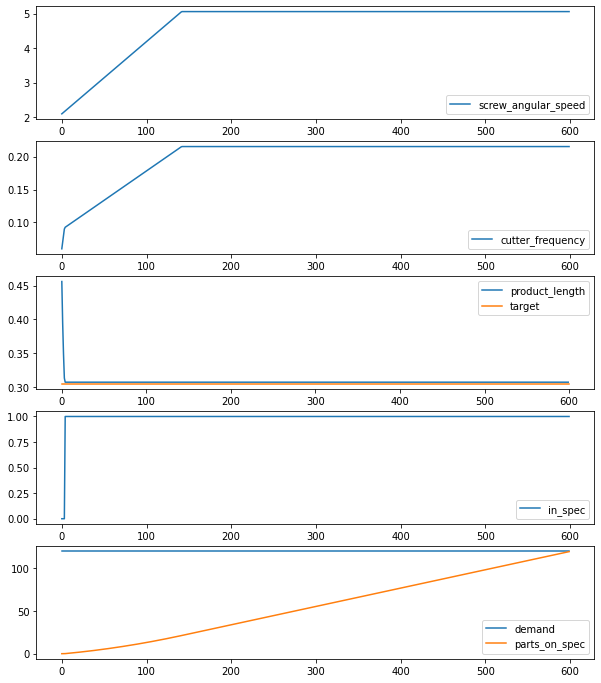

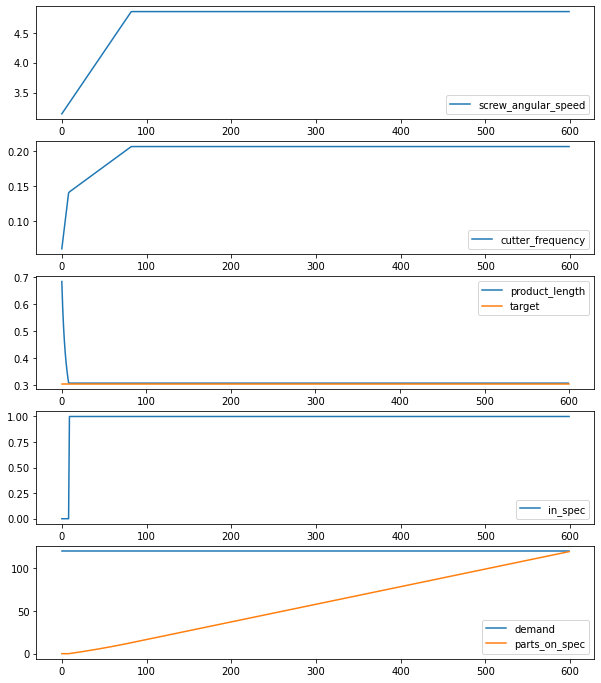

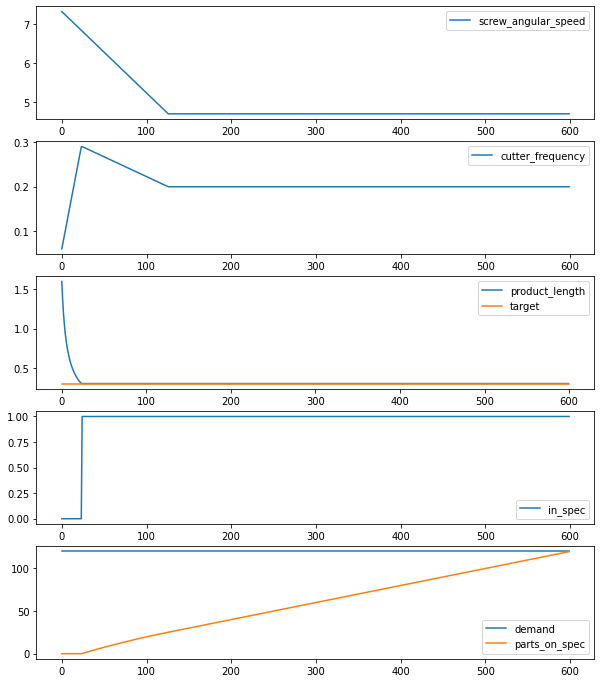

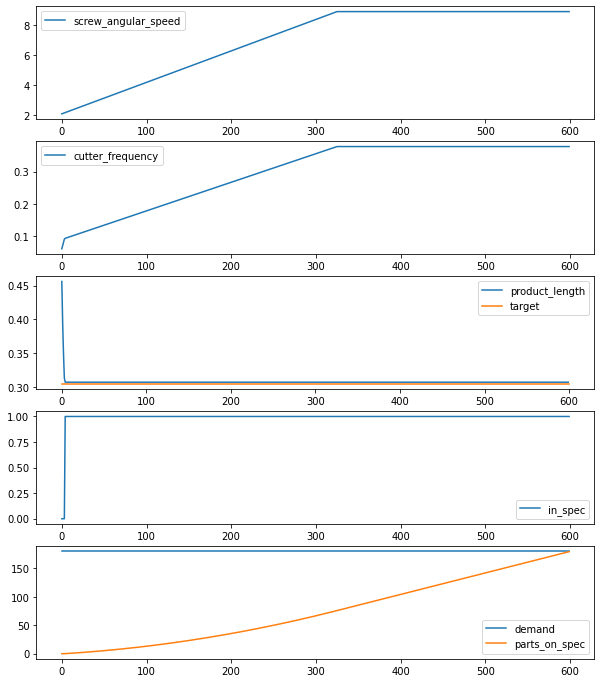

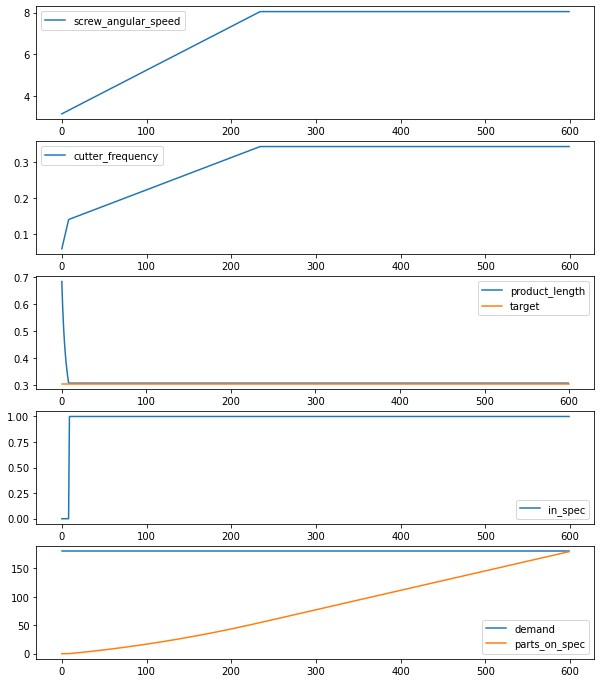

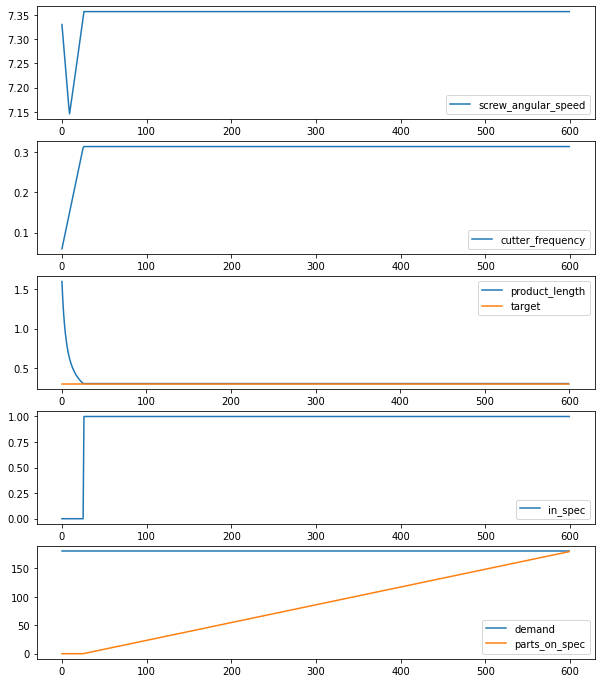

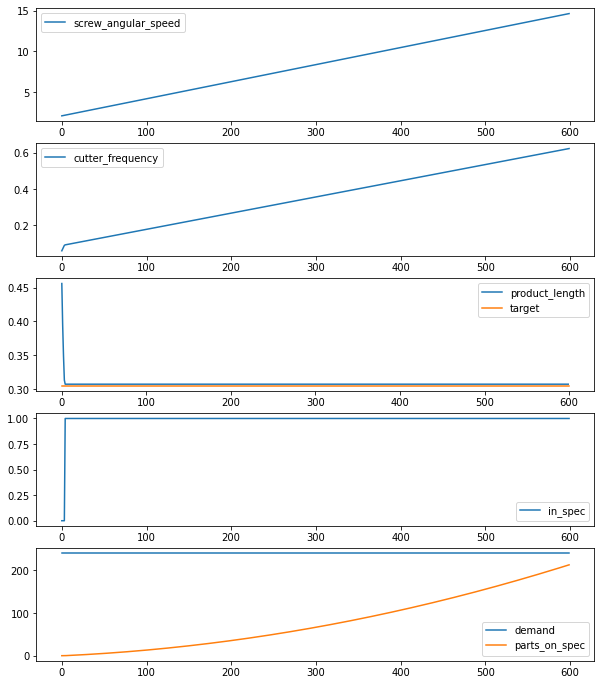

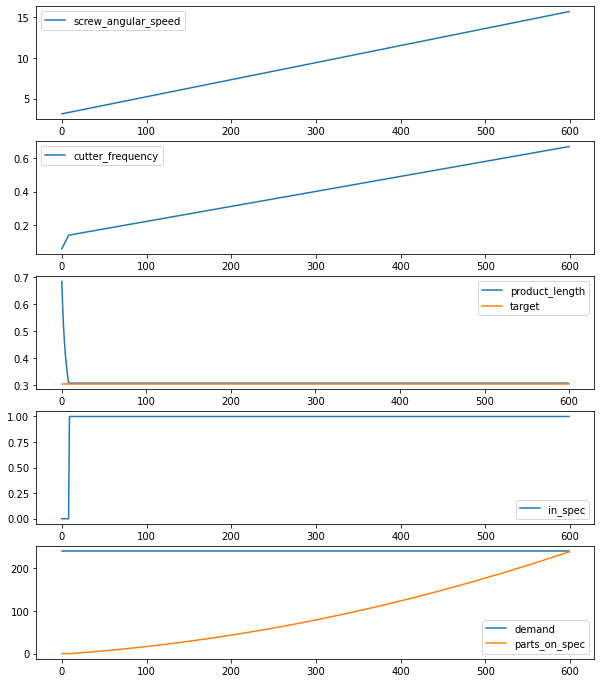

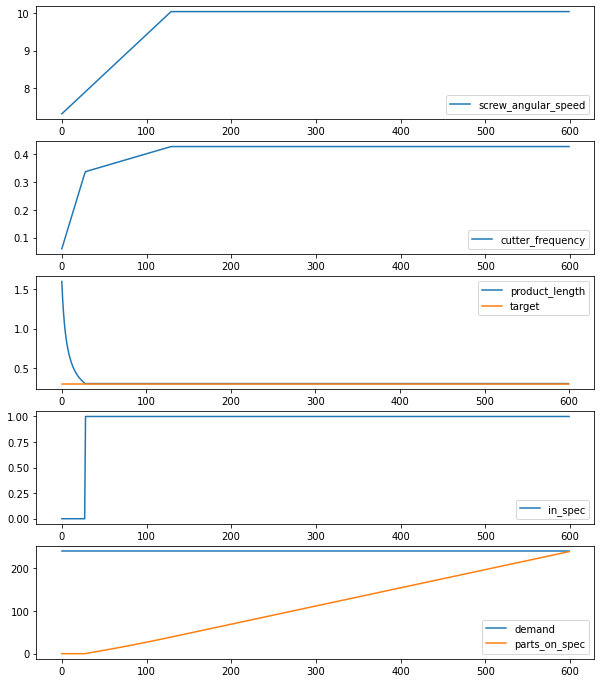

In [30]:
for config in configs:
    # these don't matter but the sim doesn't have defaults, so need to set them
    config["initial_screw_angular_acceleration"] = 0
    config["initial_cutter_acceleration"] = 0 
    states,actions = run_episode(sim, config, optimal_policy)
    states_df = pd.DataFrame(states)

    states_df["in_spec"] = states_df.apply(lambda row: is_in_spec(row["product_length"]), axis=1)

    
    fig, axes = plt.subplots(5,1, figsize=(10,12))

    states_df["screw_angular_speed"].plot(ax=axes[0])

    # actual frequency
    states_df["cutter_frequency"].plot(ax=axes[1])

    # actual length and target length
    states_df["product_length"].plot(ax=axes[2])
    N = len(states)
    axes[2].plot([0,N],[LengthTarget,LengthTarget], label='target')

    # in spec?
    states_df["in_spec"].plot(ax=axes[3])
    
    states_df[["demand", "parts_on_spec"]].plot(ax=axes[4])

    axes[0].legend()
    axes[1].legend()
    axes[2].legend()
    axes[3].legend()
    axes[4].legend()